In [ ]:
import os

%run "/content/drive/MyDrive/3D UNET.ipynb"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from inception_unet import bulid_model


(None, 256, 256, 1)


## Dice loss

In [ ]:
def dice_coeff(y_true,y_hat):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_hat = tf.keras.layers.Flatten()(y_hat)
    intersection = tf.reduce_sum(y_hat*y_true)
    return (2*intersection + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_hat))



In [ ]:
def dice_loss(y_true,y_hat):
    return 1 - dice_coeff(y_true,y_hat)

## Read data


In [ ]:
path = "/content/drive/MyDrive/archive"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
epochs = 100
batch_size = 16
lr = 1e-3
W, H =256,256

In [ ]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    if len(images) < 3 or len(masks) < 3:
        raise ValueError("Insufficient data for splitting. Make sure you have at least three samples.")
    train_x, test_x, train_y, test_y = train_test_split(images[:3064], masks, test_size=split, random_state=42)
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=split, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(path)
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)



## Model
**bold text**


In [ ]:
 model = bulid_model()
 model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coeff,'accuracy'])

(None, 256, 256, 1)


In [ ]:
callbacks = [

        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),

        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]


In [ ]:
model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Epoch 1/100
123/123 [==============================] - 122s 866ms/step - loss: 0.9012 - dice_coeff: 0.0990 - accuracy: 0.7921 - val_loss: 0.9668 - val_dice_coeff: 0.0331 - val_accuracy: 0.0168 - lr: 0.0010
Epoch 2/100
123/123 [==============================] - 104s 847ms/step - loss: 0.8378 - dice_coeff: 0.1627 - accuracy: 0.9449 - val_loss: 0.9277 - val_dice_coeff: 0.0719 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 3/100
123/123 [==============================] - 104s 848ms/step - loss: 0.7522 - dice_coeff: 0.2480 - accuracy: 0.9740 - val_loss: 0.8056 - val_dice_coeff: 0.1941 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 4/100
123/123 [==============================] - 107s 865ms/step - loss: 0.7070 - dice_coeff: 0.2934 - accuracy: 0.9766 - val_loss: 0.8303 - val_dice_coeff: 0.1693 - val_accuracy: 0.9571 - lr: 0.0010
Epoch 5/100
123/123 [==============================] - 104s 847ms/step - loss: 0.6750 - dice_coeff: 0.3253 - accuracy: 0.9768 - val_loss: 0.6794 - val_dice_coeff: 0.3200 - val_

UnknownError: ignored

In [ ]:
history = model.history.history
print(list(history.keys()))


['loss', 'dice_coeff', 'accuracy', 'val_loss', 'val_dice_coeff', 'val_accuracy', 'lr']


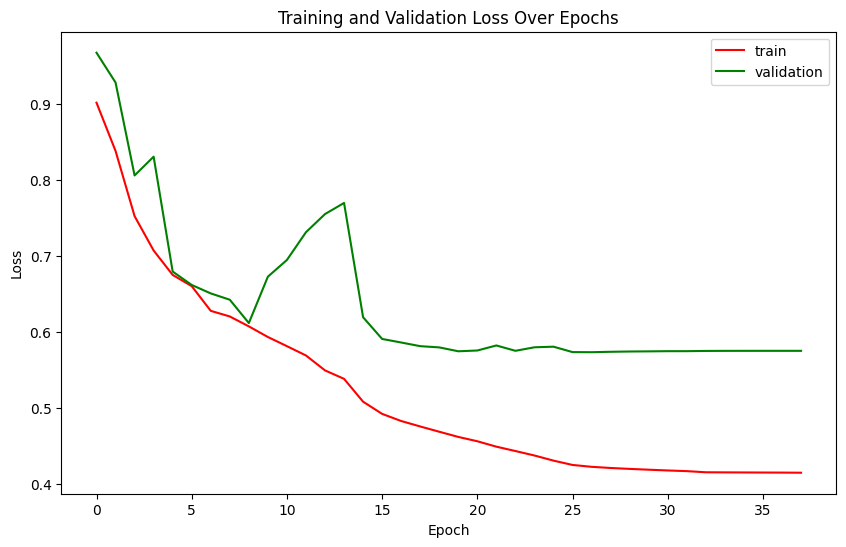

dict_keys(['loss', 'dice_coeff', 'accuracy', 'val_loss', 'val_dice_coeff', 'val_accuracy', 'lr'])


In [ ]:
history = model.history.history  # Access the history attribute

# Create a new figure and plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='train', color='r')
plt.plot(history['val_loss'], label='validation', color='g')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()
print(history.keys())

In [ ]:
result= model.evaluate(valid_dataset)

print(f"Test Loss:{result[0]}")
print(f"Test dice coeff:{result[1]}")
print(f"Test Accuarcy:{result[2]*100} %")


31/31 [==============================] - 8s 243ms/step - loss: 0.5748 - dice_coeff: 0.4266 - accuracy: 0.9830
Test Loss:0.5747753381729126
Test dice coeff:0.4266284704208374
Test Accuarcy:98.29979538917542 %


1/1 [==============================] - 1s 702ms/step
[7]
1/1 [==============================] - 0s 43ms/step
[5]
1/1 [==============================] - 0s 40ms/step
[13]
1/1 [==============================] - 0s 50ms/step
[12]
1/1 [==============================] - 0s 49ms/step
[1]
1/1 [==============================] - 0s 43ms/step
[0]
1/1 [==============================] - 0s 50ms/step
[11]
1/1 [==============================] - 0s 45ms/step
[9]
1/1 [==============================] - 0s 48ms/step
[14]
1/1 [==============================] - 0s 37ms/step
[11]
1/1 [==============================] - 0s 45ms/step
[1]
1/1 [==============================] - 0s 30ms/step
[7]


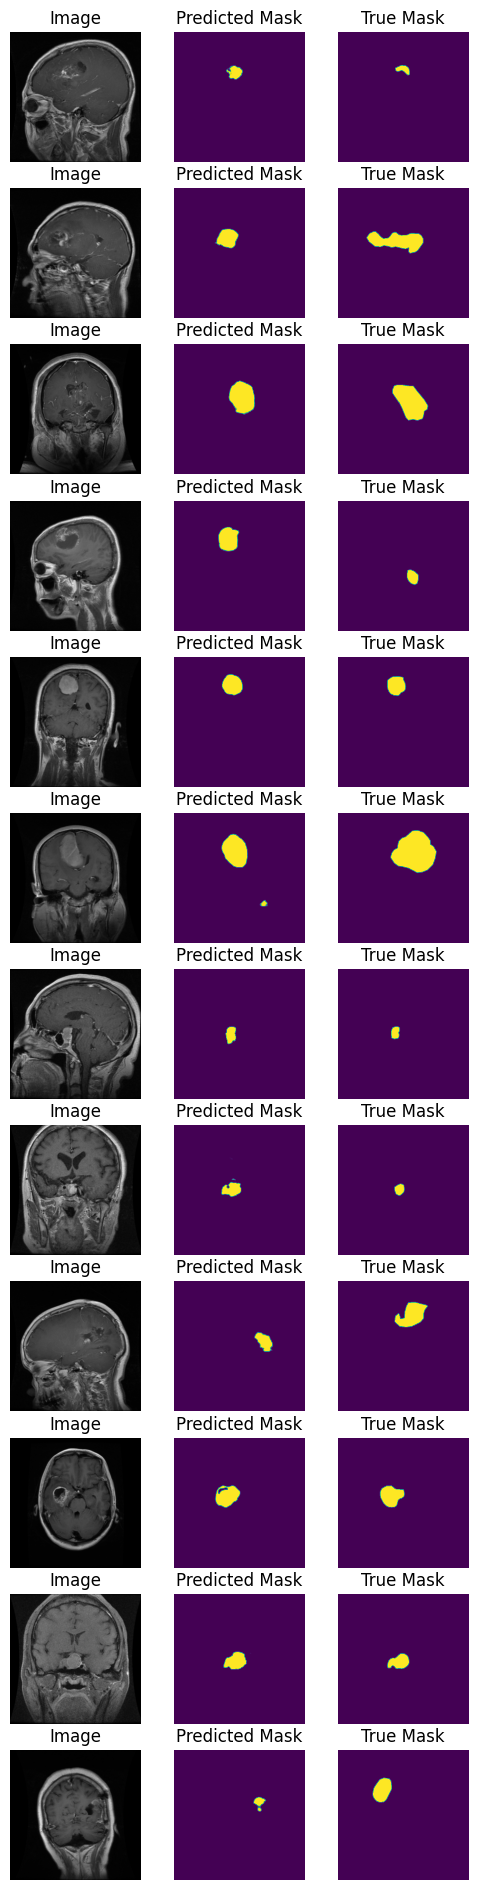

In [ ]:
num_samples = 12  # Specify the number of samples you want to visualize

visualization_dataset = valid_dataset.take(num_samples)
plt.figure(figsize=(6, 2*num_samples))
# Assuming valid_dataset provides tuples (image, mask)
for counter, (img_data, true_mask) in enumerate(visualization_dataset):
    # Expand dimensions if necessary (e.g., for grayscale images)
    # true_mask = np.expand_dims(true_mask, -1)

    # Make predictions
    prediction = model.predict(img_data)
    no_of_batch = np.random.randint(0,16,1)
    print(no_of_batch)

    # Plotting
    plt.subplot(num_samples, 3, 3 * counter + 1)
    plt.imshow(img_data[no_of_batch[0]])  # Accessing the first element in the batch
    plt.title("Image")
    plt.axis('off')

    plt.subplot(num_samples, 3, 3 * counter + 2)
    plt.imshow(prediction[no_of_batch[0]])  # Accessing the first element in the batch
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(num_samples, 3, 3 * counter + 3)
    plt.imshow(true_mask[no_of_batch[0]])  # Assuming true_mask is the ground truth mask
    plt.title('True Mask')
    plt.axis('off')

plt.show()